In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py

# --- HYPERPARAMETERS (Must match your trained model) ---
LATENT_DIM = 128
IMAGE_CHANNELS = 4
TARGET_SIZE = 64
ORIGINAL_SIZE = 108
BASE_CHANNELS = 32
IMAGE_MEAN = [0.5] * IMAGE_CHANNELS
IMAGE_STD = [0.5] * IMAGE_CHANNELS
MODEL_SAVE_PATH = 'vae_checkpoint_4ch_64patch.pth' # Path to your trained weights
DATA_FILE_PATH = 'semi_supervised_test_i_snr_20.hdf5'

# ======================================================================
# CORE MODEL AND DATA UTILITIES (Simplified definitions from training script)
# ======================================================================

# --- Placeholder/Required Data Structure ---
class NumPyVAEDataset(Dataset):
    """Placeholder for the actual dataset class used during training."""
    def __init__(self, data_array: np.ndarray):
        self.data = data_array.astype(np.float32)
        self.transform = transforms.Compose([
            transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
        ])
        self.start_index = (ORIGINAL_SIZE - TARGET_SIZE) // 2
        self.end_index = self.start_index + TARGET_SIZE

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        image_tensor = torch.from_numpy(self.data[idx])
        # Central Crop (64x64 from 108x108)
        image_tensor_cropped = image_tensor[:, self.start_index:self.end_index, self.start_index:self.end_index]
        image_tensor_cropped = self.transform(image_tensor_cropped)
        return image_tensor_cropped

def percentile_normalize_channel_wise(data_array_raw, low_percentile=10, high_percentile=99.7):
    """Performs channel-wise percentile scaling across the entire dataset."""
    # Logic is assumed correct from previous step
    data_array = data_array_raw[:, 1:5, :, :].astype(np.float32)
    N, C, H, W = data_array.shape
    reshaped_data = data_array.transpose(1, 0, 2, 3).reshape(C, -1)
    
    p_low = np.percentile(reshaped_data, low_percentile, axis=1)
    p_high = np.percentile(reshaped_data, high_percentile, axis=1)

    p_low_broadcast = p_low.reshape(1, C, 1, 1)
    p_high_broadcast = p_high.reshape(1, C, 1, 1)
    
    data_range = p_high_broadcast - p_low_broadcast
    data_range[data_range == 0] = 1e-10 
    
    data_array_norm = np.clip(data_array, p_low_broadcast, p_high_broadcast)
    data_array_norm = (data_array_norm - p_low_broadcast) / data_range
    data_array_norm[np.isnan(data_array_norm)] = 0.0
    
    return data_array_norm

class ConvolutionalVAE(nn.Module):
    """The VAE architecture class (structure must match the trained model)."""
    def __init__(self, target_size=TARGET_SIZE, latent_dim=LATENT_DIM, 
                 in_channels=IMAGE_CHANNELS, base_channels=BASE_CHANNELS):
        super(ConvolutionalVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_layers = 3 # 64x64 -> 8x8 requires 3 layers
        self.FINAL_SPATIAL_SIZE = 8
        
        encoder_channels = [in_channels, base_channels, base_channels * 2, base_channels * 4]
        
        # --- Encoder Layers ---
        self.encoder_layers = nn.ModuleList()
        for i in range(self.num_layers):
            self.encoder_layers.append(
                nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=4, stride=2, padding=1)
            )
        
        FINAL_CHANNELS = encoder_channels[-1] # 128
        self.flatten_size = FINAL_CHANNELS * self.FINAL_SPATIAL_SIZE * self.FINAL_SPATIAL_SIZE

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)

        # --- Decoder Layers ---
        self.fc_z = nn.Linear(latent_dim, self.flatten_size)
        self.decoder_layers = nn.ModuleList()
        for i in range(self.num_layers):
            in_ch = encoder_channels[self.num_layers - i]
            out_ch = encoder_channels[self.num_layers - i - 1]
            self.decoder_layers.append(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoder
        for layer in self.encoder_layers:
            x = F.relu(layer(x))
        x = x.view(x.size(0), -1) 
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        # Decoder
        x = self.fc_z(z)
        final_encoder_channels = self.encoder_layers[-1].out_channels
        x = x.view(x.size(0), final_encoder_channels, self.FINAL_SPATIAL_SIZE, self.FINAL_SPATIAL_SIZE) 
        
        for i, layer in enumerate(self.decoder_layers):
            if i == self.num_layers - 1:
                reconstructed_x = torch.tanh(layer(x))
            else:
                x = F.relu(layer(x))
        
        return reconstructed_x, mu, logvar, z

# ======================================================================
# 4. INTERPOLATION AND VISUALIZATION LOGIC
# ======================================================================

def interpolate_latent_space(model, z1, z2, num_steps, device):
    """
    Interpolates linearly between two latent vectors and reconstructs the images.
    """
    # Create an array of interpolation factors (0.0 to 1.0)
    alphas = np.linspace(0.0, 1.0, num_steps)
    
    # Pre-allocate array for reconstructed images
    reconstructions = []
    
    with torch.no_grad():
        for alpha in alphas:
            # Linear interpolation: z_interp = (1 - alpha) * z1 + alpha * z2
            z_interp = (1.0 - alpha) * z1 + alpha * z2
            
            # Pass the interpolated latent vector through the decoder
            x = model.fc_z(z_interp)
            
            # Reshape back to feature map
            final_encoder_channels = model.encoder_layers[-1].out_channels
            x = x.view(x.size(0), final_encoder_channels, model.FINAL_SPATIAL_SIZE, model.FINAL_SPATIAL_SIZE) 

            # Run through ConvTranspose layers
            for i, layer in enumerate(model.decoder_layers):
                if i == model.num_layers - 1:
                    reconstructed_x = torch.tanh(layer(x))
                else:
                    x = F.relu(layer(x))
            
            reconstructions.append(reconstructed_x.cpu().squeeze(0))

    return reconstructions

def plot_interpolation_sequence(reconstructions, filename='interpolation_sequence.png', images_per_row=10):
    """ Plots the sequence of reconstructed images in a grid. """
    
    # Setup 3-channel denormalization for visualization
    mean_3ch = IMAGE_MEAN[:3]
    std_3ch = IMAGE_STD[:3]
    inv_normalize_3ch = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean_3ch, std_3ch)],
        std=[1/s for s in std_3ch]
    )

    num_steps = len(reconstructions)
    num_rows = int(np.ceil(num_steps / images_per_row))
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 1.5, num_rows * 1.5))
    axes = axes.flatten()

    for i in range(num_steps):
        img_tensor = reconstructions[i]
        
        # Denormalize and convert to HWC (use first 3 channels)
        img_np = inv_normalize_3ch(img_tensor[:3, :, :]).permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)

        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f"{i}", fontsize=8)
        ax.axis('off')

    # Turn off any unused axes
    for j in range(num_steps, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Latent Interpolation Sequence ({num_steps} Steps)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename)
    plt.close()
    print(f"Interpolation sequence plot saved to {filename}")


In [ ]:

DATA_FILE_PATH = 'semi_supervised_test_i_snr_20.hdf5' 
INTERPOLATION_STEPS = 10

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# --- 1. Data Loading ---
print(f"Loading data from {DATA_FILE_PATH}...")
try:
    with h5py.File(DATA_FILE_PATH, 'r') as hf:
        data_array_raw = hf['images'][:] 
        # Only need two random indices for interpolation
        random_indices = np.random.choice(data_array_raw.shape[0], 2, replace=False)
except Exception as e:
    print(f"FATAL ERROR: Could not load HDF5 data: {e}. Exiting.")
    raise SystemExit(1)

# Preprocess the data array once
preprocessed_data_array = percentile_normalize_channel_wise(data_array_raw, low_percentile=10, high_percentile=99.7)

# Create a DataLoader just to get the data efficiently (we won't use the whole loop)
data_loader = DataLoader(NumPyVAEDataset(preprocessed_data_array), batch_size=2, shuffle=False)

# --- 2. Model Loading ---
print(f"\nLoading trained model from {MODEL_SAVE_PATH}...")
model = ConvolutionalVAE(target_size=TARGET_SIZE, latent_dim=LATENT_DIM).to(torch.float32).to(device)

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"Error: Checkpoint file not found at {MODEL_SAVE_PATH}. Cannot perform evaluation.")
    raise SystemExit(1)
    
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)
model.eval()




Using device: mps
Loading data from semi_supervised_test_i_snr_20.hdf5...

Loading trained model from vae_checkpoint_4ch_64patch.pth...


In [21]:
# --- Configuration for chosen images ---
INDEX_A = 207  # Example: Index of the first image in the dataset
INDEX_B = 232  # Example: Index of the second image in the dataset

# --- 3. Extract Latent Codes for Two Images by Index ---

try:
    # 1. Get image tensors directly from the dataset using the chosen indices
    # Dataset returns a single tensor (C, H, W)
    image_tensor_A = data_loader.dataset[INDEX_A]
    image_tensor_B = data_loader.dataset[INDEX_B]

    # 2. Add a batch dimension (C, H, W) -> (1, C, H, W) and move to device
    image1 = image_tensor_A.to(torch.float32).to(device).unsqueeze(0)
    image2 = image_tensor_B.to(torch.float32).to(device).unsqueeze(0)

    # 3. Check for valid indices
    if image1.shape[0] == 0 or image2.shape[0] == 0:
        raise ValueError("Selected indices returned empty tensors.")

    # 4. Extract mu (mean) for the start (z1) and end (z2) points
    # The VAE expects the batch dimension, which we added with unsqueeze(0)
    _, mu1, _, _ = model(image1)
    _, mu2, _, _ = model(image2)
    
    # Use the mu vectors as the reliable latent codes for interpolation
    z1 = mu1
    z2 = mu2
    
    print(f"Successfully extracted latent codes for images: Index {INDEX_A} and Index {INDEX_B}.")

except IndexError:
    print(f"Error: Chosen index ({INDEX_A} or {INDEX_B}) is out of bounds for the dataset (Size: {len(data_loader.dataset)}).")
    raise SystemExit(1)
except Exception as e:
    print(f"Error during feature extraction or device transfer: {e}.")
    raise SystemExit(1)

Successfully extracted latent codes for images: Index 207 and Index 232.


In [10]:
data_loader.dataset[0].shape

torch.Size([4, 64, 64])

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Assume IMAGE_MEAN, IMAGE_STD, IMAGE_CHANNELS, TARGET_SIZE are globally defined

def plot_10x10_image_grid(dataset, start_index=0, title="Image Morphology Check"):
    """
    Plots a 10x10 grid of images from the dataset, starting from a specified index.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset object.
        start_index (int): The index of the first image to plot.
        title (str): Title for the overall figure.
    """
    
    # 1. Setup Denormalization (using the first 3 channels)
    if len(IMAGE_MEAN) < 3:
        print("Error: IMAGE_MEAN must have at least 3 values for RGB plotting.")
        return
    
    # NOTE: Assuming the global IMAGE_MEAN and IMAGE_STD are available in the script's scope
    mean_3ch = IMAGE_MEAN[:3]
    std_3ch = IMAGE_STD[:3]
    
    inv_normalize_3ch = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean_3ch, std_3ch)],
        std=[1/s for s in std_3ch]
    )
    
    # 2. Setup Plotting Parameters
    ROWS = 10
    COLS = 10
    MAX_PLOTS = ROWS * COLS
    
    # Determine the actual indices to plot
    dataset_size = len(dataset)
    end_index = min(start_index + MAX_PLOTS, dataset_size)
    num_to_plot = end_index - start_index
    
    if num_to_plot <= 0:
        print(f"Error: No images to plot. Dataset size is {dataset_size} and start index is {start_index}.")
        return

    fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15))
    axes = axes.flatten()
    
    # 3. Iterate and Plot
    print(f"Generating {ROWS}x{COLS} grid, starting from index {start_index}...")
    
    # Iterate through the global indices, starting at start_index
    for i, global_idx in enumerate(range(start_index, end_index)):
        
        # Get item from dataset using the global index
        try:
            image_tensor = dataset[global_idx]
        except Exception as e:
            print(f"Failed to load image at index {global_idx}: {e}. Stopping.")
            break

        # Slice to the first 3 channels and move to CPU
        image_3ch = image_tensor[:3, :, :].cpu()
        
        # Denormalize, transpose (C, H, W -> H, W, C), and convert to NumPy
        image_np = inv_normalize_3ch(image_3ch).permute(1, 2, 0).numpy()
        
        # Clip to [0, 1] range for safe plotting
        image_np = np.clip(image_np, 0, 1)

        # Plotting
        ax = axes[i]
        ax.imshow(image_np)
        
        # Add the global index as the title
        ax.set_title(f"Idx: {global_idx}", fontsize=8)
        
        ax.axis('off') # Hide axes ticks and labels

    # Remove any remaining empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"{title} (Starting Index: {start_index})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Example of How to Call the Function ---
# Assume 'data_loader' is your DataLoader instance
# plot_10x10_image_grid(data_loader.dataset, start_index=150)

Generating 10x10 grid, starting from index 200...


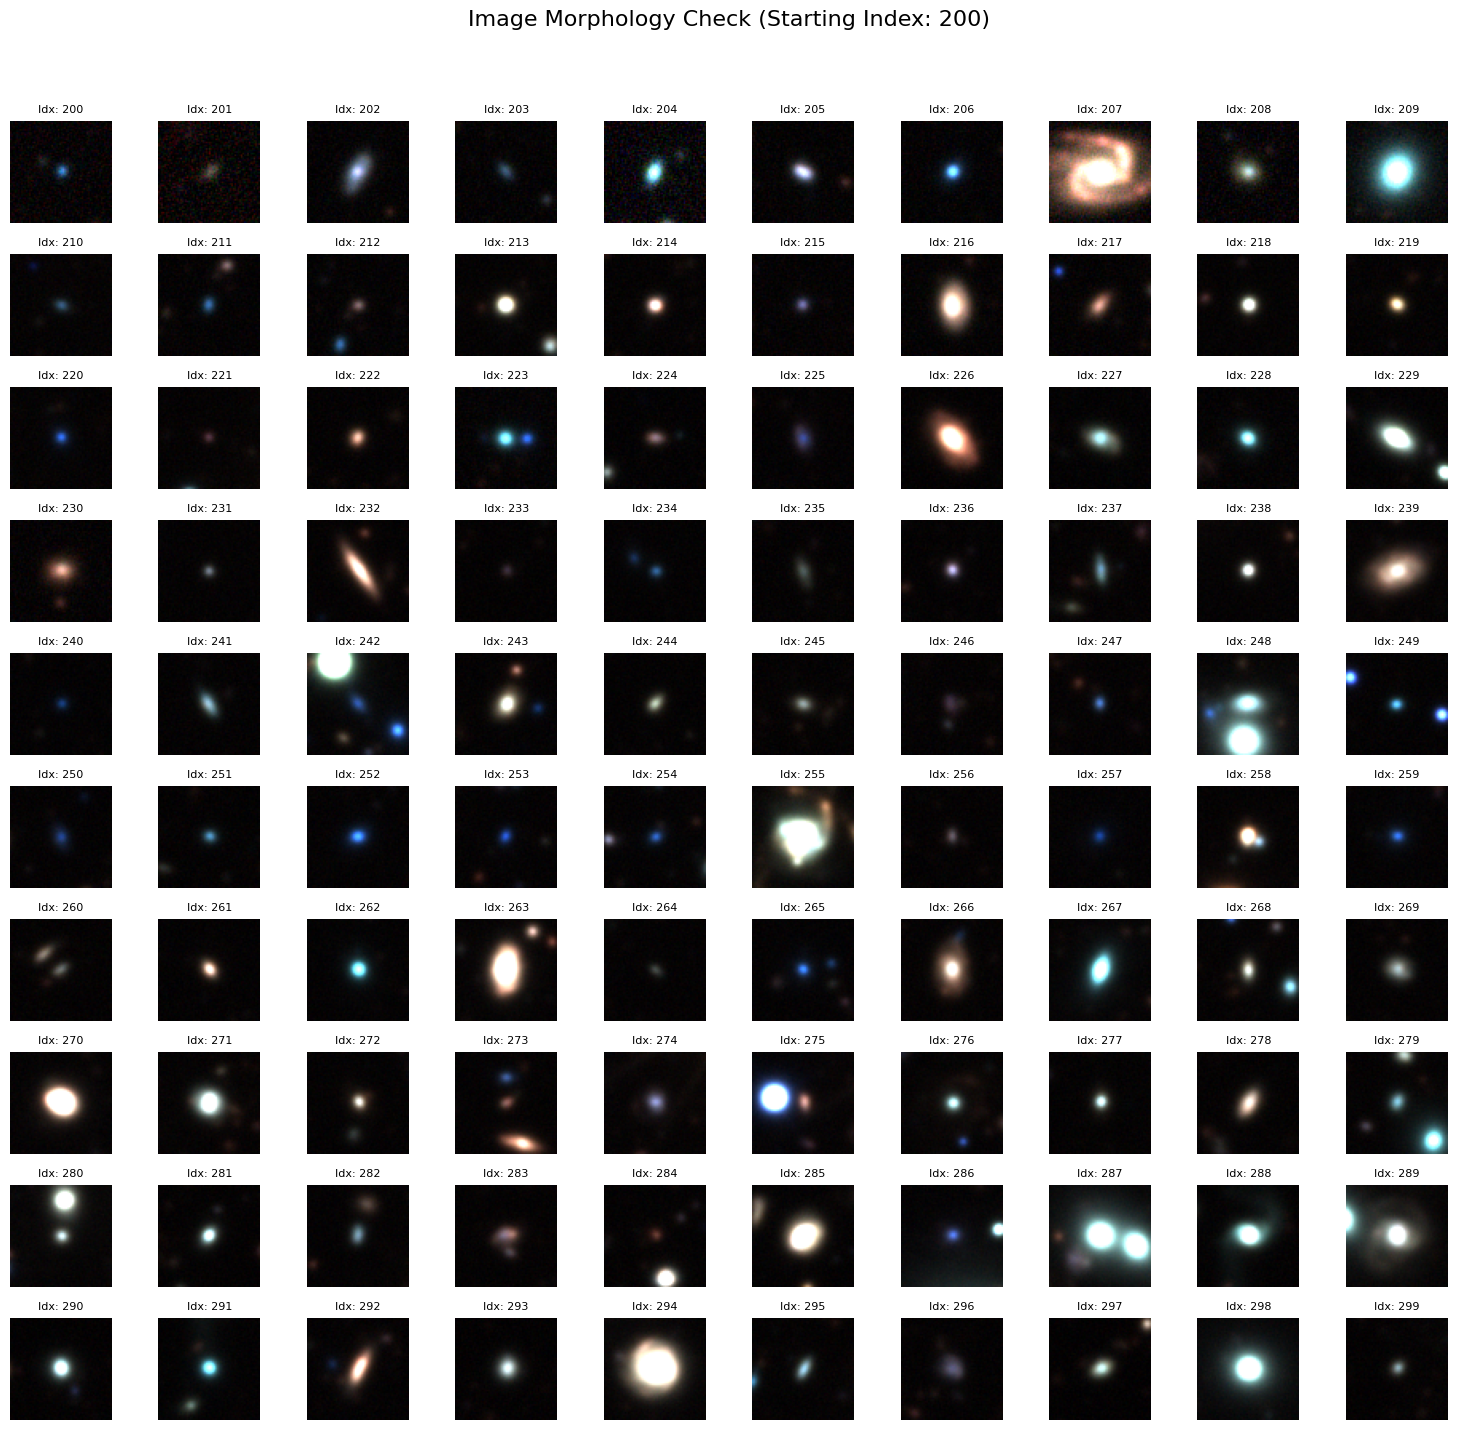

In [20]:
plot_10x10_image_grid(data_loader.dataset, start_index=200)

In [23]:
INTERPOLATION_STEPS=20

# --- 4. Perform Interpolation and Plot ---
print(f"Performing {INTERPOLATION_STEPS} steps of latent space interpolation...")
reconstructions = interpolate_latent_space(model, z1, z2, INTERPOLATION_STEPS, device)

plot_interpolation_sequence(reconstructions, images_per_row=10)

print("\nLatent space interpolation successfully visualized.")

Performing 20 steps of latent space interpolation...
Interpolation sequence plot saved to interpolation_sequence.png

Latent space interpolation successfully visualized.


In [35]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

def get_modified_resnet(in_channels=4, model_name='resnet18'):
    """Loads a pre-trained ResNet and modifies the first conv layer for 4 input channels."""
    
    # 1. Load the pre-trained model weights
    # We use ResNet18_Weights.IMAGENET1K_V1 which contains ImageNet weights
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Get the existing Conv1 layer (which takes 3 input channels)
    original_conv1 = model.conv1
    
    # 2. Create a new Conv1 layer for 4 input channels
    # Keep all other parameters (out_channels=64, kernel_size, stride, padding, bias) the same
    new_conv1 = nn.Conv2d(
        in_channels, 
        original_conv1.out_channels, 
        kernel_size=original_conv1.kernel_size, 
        stride=original_conv1.stride, 
        padding=original_conv1.padding, 
        bias=original_conv1.bias
    )
    
    # 3. Transfer the pre-trained weights to the new layer
    # Since the new layer has 4 channels and the old one has 3, we copy the weights
    # for the first 3 channels and initialize the 4th channel's weights randomly (or to zeros).
    # We copy the weights using the first 3 channels of the original weights.
    new_conv1.weight.data[:, :3, :, :] = original_conv1.weight.data
    
    # Initialize the new 4th channel's weights (e.g., by averaging the first 3 or setting to zero)
    # Using the mean of the first three channels is a common heuristic:
    new_conv1.weight.data[:, 3, :, :] = original_conv1.weight.data[:, :3, :, :].mean(dim=1)

    # 4. Replace the original layer with the new one
    model.conv1 = new_conv1
    
    # 5. Modify the final layer (Fully Connected) to output the desired embedding size
    # We cut off the classification head and just use the feature extractor backbone.
    # The output size of the backbone is typically 512 for ResNet18.
    model = nn.Sequential(*list(model.children())[:-1]) # Remove the classification layer
    
    return model

In [36]:
# Assuming you have a working get_dataloader function and device setup

@torch.no_grad()
def extract_foundation_features(model, dataloader, device):
    """
    Extracts features using the modified pre-trained ResNet.
    """
    model.eval()
    all_features = []
    
    pbar = tqdm(dataloader, desc="Extracting ResNet Embeddings", unit="batch")
    
    for x in pbar:
        if isinstance(x, (list, tuple)):
            x = x[0]
            
        x = x.to(torch.float32).to(device)
        
        # Forward pass through the ResNet backbone
        features = model(x)
        
        # Features will be (Batch, 512, 1, 1). We squeeze out the 1x1 dimensions.
        features = features.squeeze()
        
        all_features.append(features.cpu())
        
    return torch.cat(all_features, dim=0).numpy()

if __name__ == '__main__':
    # --- Setup ---
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Load your existing data_loader (64x64 patches, 4 channels)
    # data_loader = get_dataloader(...) 
    
    # --- 1. Load and Modify Foundation Model ---
    foundation_model = get_modified_resnet(in_channels=IMAGE_CHANNELS).to(torch.float32).to(device)
    print("ResNet-18 model modified and loaded successfully.")

    # --- 2. Extract Embeddings ---
    # features_Z_VAE = extract_features(vae_model, data_loader, device) # Your VAE embeddings
    features_Z_ResNet = extract_foundation_features(foundation_model, data_loader, device)
    
    # --- 3. Comparison ---
    print(f"\nVAE Latent Dim (Example): 128")
    print(f"ResNet Embedding Dim: {features_Z_ResNet.shape[1]}")
    
    # Now you can compare the two sets of embeddings:
    # 1. Compare Clustering: Apply UMAP/t-SNE to both VAE and ResNet embeddings.
    #    (You may need to reduce the ResNet features from 512D to 128D first, 
    #     or let UMAP handle the reduction.)
    # 2. Compare Performance: Use the embeddings as input for a simple linear classifier 
    #    to predict a known property (e.g., redshift, if you have labels).

ResNet-18 model modified and loaded successfully.


Extracting ResNet Embeddings:   0%|          | 0/45 [00:00<?, ?batch/s]/Users/xuduo/miniforge3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting ResNet Embeddings: 100%|██████████| 45/45 [00:00<00:00, 84.39batch/s]


VAE Latent Dim (Example): 128
ResNet Embedding Dim: 512


In [37]:
features_Z_ResNet.shape

(2830, 512)

In [38]:
np.save('features_Z_from_resnet.npy', features_Z_ResNet) # Save the extracted features to a file. features_Z_ResNet.shape

In [39]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import umap.umap_ as umap
import matplotlib.pyplot as plt
import os
import h5py
from torchvision import transforms

# --- HYPERPARAMETERS (Must match data preparation) ---
IMAGE_CHANNELS = 4
TARGET_SIZE = 64  # VAE input size (and ResNet input size after cropping)
ORIGINAL_SIZE = 108
BATCH_SIZE = 64
IMAGE_MEAN = [0.5] * IMAGE_CHANNELS
IMAGE_STD = [0.5] * IMAGE_CHANNELS
DATA_FILE_PATH = 'semi_supervised_test_i_snr_20.hdf5'


def load_redshifts(file_path):
    """Loads redshift data from HDF5 for color encoding."""
    try:
        with h5py.File(file_path, 'r') as hf:
            return hf['redshifts'][:]
    except Exception as e:
        print(f"Warning: Could not load redshifts from HDF5: {e}.")
        return None

class NumPyVAEDataset(Dataset):
    """ Loads data, performs central crop, and applies normalization. """
    def __init__(self, data_array: np.ndarray):
        self.data = data_array.astype(np.float32)
        
        self.transform = transforms.Compose([
            transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
        ])
        
        # Calculate crop indices for 64x64 patch from 108x108
        self.start_index = (ORIGINAL_SIZE - TARGET_SIZE) // 2
        self.end_index = self.start_index + TARGET_SIZE

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        image_tensor = torch.from_numpy(self.data[idx])
        image_tensor_cropped = image_tensor[:, self.start_index:self.end_index, self.start_index:self.end_index]
        image_tensor_cropped = self.transform(image_tensor_cropped)
        return image_tensor_cropped

def get_dataloader(data_array: np.ndarray, batch_size: int = BATCH_SIZE) -> DataLoader:
    """ Utility function to create and return the DataLoader instance. """
    dataset = NumPyVAEDataset(data_array)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# ======================================================================
# 2. FOUNDATION MODEL MODIFICATION (ResNet)
# ======================================================================

def get_modified_resnet(in_channels=IMAGE_CHANNELS):
    """Loads pre-trained ResNet-18, modifies the first layer for 4 channels, and removes the classification head."""
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    
    # Modify Conv1 layer for 4 input channels
    original_conv1 = model.conv1
    new_conv1 = nn.Conv2d(
        in_channels, 
        original_conv1.out_channels, 
        kernel_size=original_conv1.kernel_size, 
        stride=original_conv1.stride, 
        padding=original_conv1.padding, 
        bias=original_conv1.bias
    )
    
    # Transfer weights: copy the first 3 channels and use the mean for the 4th
    new_conv1.weight.data[:, :3, :, :] = original_conv1.weight.data
    new_conv1.weight.data[:, 3, :, :] = original_conv1.weight.data[:, :3, :, :].mean(dim=1)

    model.conv1 = new_conv1
    
    # Remove the final classification layer (model.fc) to get the feature backbone
    model = nn.Sequential(*list(model.children())[:-1])
    
    return model

@torch.no_grad()
def extract_foundation_features(model, dataloader, device):
    """Extracts 512D features using the modified ResNet backbone."""
    model.eval()
    all_features = []
    pbar = tqdm(dataloader, desc="Extracting ResNet Embeddings", unit="batch")
    
    for x in pbar:
        if isinstance(x, (list, tuple)):
            x = x[0]
            
        x = x.to(torch.float32).to(device)
        
        features = model(x)
        features = features.squeeze() # Output shape: (Batch, 512)
        
        all_features.append(features.cpu())
        
    return torch.cat(all_features, dim=0).numpy()

# ======================================================================
# 3. PLOTTING FUNCTION
# ======================================================================

def plot_umap_with_color_encoding(embedding, redshifts, filename='umap_resnet_redshift_colored.png'):
    """Plots the 2D UMAP embedding colored by redshift (0 to 2)."""
    Z_MIN = 0.0
    Z_MAX = 2.0
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=redshifts, 
        s=5,         
        cmap='viridis', 
        alpha=0.7,
        vmin=Z_MIN,
        vmax=Z_MAX
    )
    
    plt.gca().set_aspect('equal', 'datalim')
    
    cbar = plt.colorbar(scatter, label=f'Redshift ($z$) [Range {Z_MIN} to {Z_MAX}]')
    
    plt.title('UMAP Projection of ResNet Embeddings, Colored by Redshift', fontsize=16)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig(filename)
    plt.close()
    print(f"UMAP plot saved to {filename}")

# ======================================================================
# 4. MAIN EXECUTION
# ======================================================================

if __name__ == '__main__':
    
    # --- Device Setup ---
    device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
    print(f"Using device: {device}")

    # --- Data Loading and Preprocessing ---
    try:
        with h5py.File(DATA_FILE_PATH, 'r') as hf:
            data_array_raw = hf['images'][:] 
            redshift_data_full = hf['redshifts'][:]
            
            # 1. Perform channel-wise percentile normalization
            data_array = percentile_normalize_channel_wise(data_array_raw)
            
    except Exception as e:
        print(f"FATAL ERROR: Could not load HDF5 data: {e}. Exiting.")
        raise SystemExit(1)

    # Create DataLoader
    data_loader = get_dataloader(data_array)
    
    # --- Model Loading and Extraction ---
    print("\nLoading and modifying ResNet-18 model...")
    foundation_model = get_modified_resnet(in_channels=IMAGE_CHANNELS).to(torch.float32).to(device)

    # 1. Extract 512D ResNet Embeddings
    features_Z_ResNet = extract_foundation_features(foundation_model, data_loader, device)
    print(f"Extracted ResNet features shape: {features_Z_ResNet.shape}")

    # 2. Perform UMAP Dimensionality Reduction
    print("Performing UMAP reduction on 512D ResNet features...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features_Z_ResNet)
    print(f"UMAP Embedding shape: {embedding.shape}")

    # 3. Plot UMAP with Redshift Color Encoding
    if redshift_data_full.shape[0] == embedding.shape[0]:
        plot_umap_with_color_encoding(embedding, redshift_data_full)
    else:
        print("Error: Redshift data size does not match embedding size. Skipping plot.")

Using device: mps

Loading and modifying ResNet-18 model...


Extracting ResNet Embeddings:   0%|          | 0/45 [00:00<?, ?batch/s]/Users/xuduo/miniforge3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting ResNet Embeddings: 100%|██████████| 45/45 [00:00<00:00, 89.42batch/s]
/Users/xuduo/miniforge3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Extracted ResNet features shape: (2830, 512)
Performing UMAP reduction on 512D ResNet features...
UMAP Embedding shape: (2830, 2)
UMAP plot saved to umap_resnet_redshift_colored.png


In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import umap.umap_ as umap
import matplotlib.pyplot as plt
import timm # Library for state-of-the-art models
import os
import h5py
from torchvision import transforms

# --- HYPERPARAMETERS (Must match data preparation) ---
IMAGE_CHANNELS = 4
TARGET_SIZE = 64  # Input size for ViT (64x64 patch)
BATCH_SIZE = 64
# We will use ViT-Small (ViT-S/16) as the backbone
VIT_MODEL_NAME = 'vit_small_patch16_224' # Common ViT-S base

# ... (Assume utility functions like get_dataloader and load_redshifts are available) ...

def get_modified_vit(in_channels=IMAGE_CHANNELS, model_name=VIT_MODEL_NAME, image_size=TARGET_SIZE):
    """Loads a pre-trained ViT, modifies the patch embedding layer for 4 input channels, and removes the classification head."""
    
    # 1. Load the pre-trained ViT model (e.g., ViT-Small)
    # The 'features_only=True' option is often used, but here we load the full model and clip the head.
    model = timm.create_model(
        model_name, 
        pretrained=True, 
        img_size=image_size, # Pass the correct input size (64)
        num_classes=0        # Set num_classes=0 to remove the final classification head
    )
    
    # The patch embedding is usually the first module named 'patch_embed'
    original_patch_embed = model.patch_embed.proj
    
    # 2. Create a new Patch Embedding layer for 4 input channels
    # The output dimension (embed_dim) must remain the same (768 for ViT-S)
    new_patch_embed = nn.Conv2d(
        in_channels,
        original_patch_embed.out_channels,
        kernel_size=original_patch_embed.kernel_size,
        stride=original_patch_embed.stride,
        padding=original_patch_embed.padding,
        bias=original_patch_embed.bias is not None
    )
    
    # 3. Transfer the pre-trained weights to the new layer
    # Copy weights for the first 3 channels and use the mean for the 4th
    new_patch_embed.weight.data[:, :3, :, :] = original_patch_embed.weight.data
    # Initialize the new 4th channel's weights using the mean of the first 3
    new_patch_embed.weight.data[:, 3, :, :] = original_patch_embed.weight.data[:, :3, :, :].mean(dim=1)

    # 4. Replace the original layer
    model.patch_embed.proj = new_patch_embed
    
    return model

@torch.no_grad()
def extract_vit_features(model, dataloader, device):
    """Extracts features using the modified ViT backbone."""
    model.eval()
    all_features = []
    
    pbar = tqdm(dataloader, desc="Extracting ViT Embeddings", unit="batch")
    
    for x in pbar:
        if isinstance(x, (list, tuple)):
            x = x[0]
            
        x = x.to(torch.float32).to(device)
        
        # Forward pass through the ViT backbone
        # The output of ViT's features will be the CLS token or the pooled result
        features = model(x) 
        
        # The features should be (Batch, Embed_Dim). If not, squeeze/reshape.
        if features.ndim > 2:
            features = features.squeeze() # Remove extra 1x1 spatial dimensions if present
            
        all_features.append(features.cpu())
        
    return torch.cat(all_features, dim=0).numpy()

# ======================================================================
# 3. PLOTTING FUNCTION
# ======================================================================

def plot_umap_with_color_encoding(embedding, redshifts, filename='umap_resnet_redshift_colored.png'):
    """Plots the 2D UMAP embedding colored by redshift (0 to 2)."""
    Z_MIN = 0.0
    Z_MAX = 2.0
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=redshifts, 
        s=5,         
        cmap='viridis', 
        alpha=0.7,
        vmin=Z_MIN,
        vmax=Z_MAX
    )
    
    plt.gca().set_aspect('equal', 'datalim')
    
    cbar = plt.colorbar(scatter, label=f'Redshift ($z$) [Range {Z_MIN} to {Z_MAX}]')
    
    plt.title('UMAP Projection of ViT Embeddings, Colored by Redshift', fontsize=16)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.savefig(filename)
    plt.close()
    print(f"UMAP plot saved to {filename}")
    
    
# --- Main Execution Flow ---
if __name__ == '__main__':
    # ... (Data loading, normalization, and DataLoader setup here) ...
    # This assumes 'data_array' and 'redshift_data_full' are loaded and preprocessed
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # --- Load Data (Placeholder for full loading sequence) ---
    # Example: Assuming data_array and data_loader are ready
    # data_array = ...
    # data_loader = ...
    
    # --- Model Loading and Extraction ---
    print("\nLoading and modifying ViT-Small model...")
    foundation_model = get_modified_vit(in_channels=IMAGE_CHANNELS).to(torch.float32).to(device)

    # 1. Extract ViT Embeddings (typically 768D for ViT-S)
    features_Z_ViT = extract_vit_features(foundation_model, data_loader, device)
    print(f"Extracted ViT features shape: {features_Z_ViT.shape}")

    # 2. Perform UMAP Dimensionality Reduction
    print("Performing UMAP reduction on ViT features...")
    # NOTE: UMAP is highly effective at reducing high-dimensional embeddings like ViT's
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(features_Z_ViT)
    print(f"UMAP Embedding shape: {embedding.shape}")

    # 3. Plot UMAP with Redshift Color Encoding
    if redshift_data_full.shape[0] == embedding.shape[0]:
        plot_umap_with_color_encoding(embedding, redshift_data_full, filename='umap_vit_redshift_colored.png')
    else:
        print("Error: Redshift data size does not match embedding size. Skipping plot.")

Using device: mps

Loading and modifying ViT-Small model...


Extracting ViT Embeddings:   0%|          | 0/45 [00:00<?, ?batch/s]/Users/xuduo/miniforge3/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Extracting ViT Embeddings: 100%|██████████| 45/45 [00:00<00:00, 53.67batch/s]
/Users/xuduo/miniforge3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Extracted ViT features shape: (2830, 384)
Performing UMAP reduction on ViT features...
UMAP Embedding shape: (2830, 2)
UMAP plot saved to umap_vit_redshift_colored.png


In [41]:
features_Z_ViT.shape

(2830, 384)

In [42]:
np.save('features_Z_from_vit.npy', features_Z_ViT) # Save the extracted features to a file. features_Z_ViT.shape

In [29]:
@torch.no_grad()
def extract_features(model, dataloader, device):
    """Extracts the latent vector (z) for all data in the DataLoader."""
    model.eval()
    all_z = []
    pbar = tqdm(dataloader, desc="Extracting Embeddings", unit="batch")
    
    for batch_x in pbar:
        if isinstance(batch_x, (list, tuple)):
             batch_x = batch_x[0] 
        
        x = batch_x.to(torch.float32).to(device)
        
        _, _, _, z = model(x)
        all_z.append(z.cpu())
        
    return torch.cat(all_z, dim=0).numpy()

In [31]:
DATA_FILE_PATH = 'semi_supervised_test_i_snr_20.hdf5'

MODEL_SAVE_PATH = 'vae_checkpoint_4ch_64patch.pth' # Path to your trained model weights
BATCH_SIZE = 64

# --- Device Selection ---
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
print(f"Loading and preprocessing data from {DATA_FILE_PATH}...")

try:
    with h5py.File(DATA_FILE_PATH, 'r') as hf:
        data_array_raw = hf['images'][:] 
        redshift_data_full = hf['redshifts'][:] # Load redshifts too
        
        # 1. Perform channel-wise percentile normalization
        data_array = percentile_normalize_channel_wise(data_array_raw, low_percentile=10, high_percentile=99.7)
        print(f"Preprocessed data shape: {data_array.shape}")
        
except Exception as e:
    print(f"FATAL ERROR: Could not load HDF5 data or redshifts: {e}.")
    raise SystemExit(1)

# Create DataLoader (shuffle=False for consistent results)
data_loader = get_dataloader(data_array, batch_size=BATCH_SIZE)

# --- Model Setup and Loading ---
print(f"\nLoading model from {MODEL_SAVE_PATH}...")
final_model = ConvolutionalVAE(target_size=TARGET_SIZE, latent_dim=LATENT_DIM).to(torch.float32).to(device)

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"Error: Checkpoint file not found at {MODEL_SAVE_PATH}")
    raise SystemExit(1)
    
try:
    # Load weights and map to device
    checkpoint = torch.load(MODEL_SAVE_PATH, map_location=device, weights_only=True)
    final_model.load_state_dict(checkpoint)
except RuntimeError as e:
    print(f"Error loading model weights (architecture mismatch): {e}")
    raise SystemExit(1)

# ======================================================================
# RUN EVALUATION AND PLOTTING
# ======================================================================

# 1. Extract Embeddings
features_Z = extract_features(final_model, data_loader, device)
print(f"Extracted latent features shape: {features_Z.shape}")

# # 2. Perform UMAP Dimensionality Reduction
# print("Performing UMAP reduction...")
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
# embedding = reducer.fit_transform(features_Z)
# print(f"UMAP Embedding shape: {embedding.shape}")


Using device: mps
Loading and preprocessing data from semi_supervised_test_i_snr_20.hdf5...
Preprocessed data shape: (2830, 4, 108, 108)

Loading model from vae_checkpoint_4ch_64patch.pth...


Extracting Embeddings: 100%|██████████| 45/45 [00:00<00:00, 115.35batch/s]

Extracted latent features shape: (2830, 128)


In [34]:
np.save('features_Z_from_vae.npy', features_Z) # Save the extracted features to a file. features_Z.shape